# **NLP Text Classification on Fake news detection**

#### Importing packages

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mahjabeenmohiuddin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading Dataset

In [2]:
fake_news_train = pd.read_csv("kaggle_fake_train.csv")

In [3]:
fake_news_train

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


### Dropping unrequired columns

In [4]:
df_train = fake_news_train.drop(['id','title','author'], axis = True)

In [5]:
df_train.head()

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1


## Defining a function to clean text and then calling the function.

In [6]:
def clean_text(text):
    if isinstance(text, str): 
      text = text.lower()
      text = re.sub(pattern = '[^a-zA-Z]', repl = ' ', string =text)
      text = re.sub(pattern= '\s+', repl = ' ', string= text).strip()
      text = re.sub(r'[  \t]+$', '', text)  
      return text
    else:
       return ""  # Return empty string for NaN or None values
    

In [7]:
df_train['text'] = df_train['text'].apply(clean_text)
df_train['text'] 

0        house dem aide we didn t even see comey s lett...
1        ever get the feeling your life circles the rou...
2        why the truth might get you fired october the ...
3        videos civilians killed in single us airstrike...
4        print an iranian woman has been sentenced to s...
                               ...                        
20795    rapper t i unloaded on black celebrities who m...
20796    when the green bay packers lost to the washing...
20797    the macy s of today grew from the union of sev...
20798    nato russia to hold parallel exercises in balk...
20799    david swanson is an author activist journalist...
Name: text, Length: 20800, dtype: object

## Defining a function to remove stop words

In [8]:
def remove_stopwords(text):
    tokens = []
    stop_words = stopwords.words('english')
    for token in text.split():
        if token not in stop_words:
           tokens.append(token)
    return " ".join(tokens)    

In [9]:
df_train['text'] = df_train['text'].apply(remove_stopwords)
df_train['text']

0        house dem aide even see comey letter jason cha...
1        ever get feeling life circles roundabout rathe...
2        truth might get fired october tension intellig...
3        videos civilians killed single us airstrike id...
4        print iranian woman sentenced six years prison...
                               ...                        
20795    rapper unloaded black celebrities met donald t...
20796    green bay packers lost washington redskins wee...
20797    macy today grew union several great names amer...
20798    nato russia hold parallel exercises balkans pr...
20799    david swanson author activist journalist radio...
Name: text, Length: 20800, dtype: object

### Definig a function to extract stems from the text

In [10]:
def stem_words(text):
    tokens = []
    english_stemmer = PorterStemmer()
    for token in text.split():
        stemmed_token = english_stemmer.stem(token)
        tokens.append(stemmed_token)

    return " ".join(tokens)


In [11]:
df_train['text'] = df_train['text'].apply(stem_words)
df_train['text']

0        hous dem aid even see comey letter jason chaff...
1        ever get feel life circl roundabout rather hea...
2        truth might get fire octob tension intellig an...
3        video civilian kill singl us airstrik identifi...
4        print iranian woman sentenc six year prison ir...
                               ...                        
20795    rapper unload black celebr met donald trump el...
20796    green bay packer lost washington redskin week ...
20797    maci today grew union sever great name america...
20798    nato russia hold parallel exercis balkan press...
20799    david swanson author activist journalist radio...
Name: text, Length: 20800, dtype: object

### Displaying 1st 10 rows

In [12]:
df_train['text'][0:10]

0    hous dem aid even see comey letter jason chaff...
1    ever get feel life circl roundabout rather hea...
2    truth might get fire octob tension intellig an...
3    video civilian kill singl us airstrik identifi...
4    print iranian woman sentenc six year prison ir...
5    tri time jacki mason voic reason week exclus c...
6    ever wonder britain icon pop pianist get long ...
7    pari franc chose idealist tradit candid sunday...
8    donald j trump schedul make highli anticip vis...
9    week michael flynn resign nation secur advis s...
Name: text, dtype: object

## Analysing number of rows in each set

In [13]:
print(f"The number of training datapoints are = {len(df_train)}")

The number of training datapoints are = 20800


In [14]:
print(f"The number of classes in trainset are = {len(np.unique(df_train['label']))}")
print(f"The trainset class labels are = {np.unique(df_train['label'])}")

The number of classes in trainset are = 2
The trainset class labels are = [0 1]


In [15]:
print("Training Data")

class_0 = df_train[df_train["label"]==0]
class_1 = df_train[df_train["label"]==1]

print(f"The number of 0 classes are: {len(class_0)}")
print(f"The number of 1 classes are: {len(class_1)}")

Training Data
The number of 0 classes are: 10387
The number of 1 classes are: 10413


In [16]:
df_train.isna().sum()

text     0
label    0
dtype: int64

### Encoding the X variable data using Vectorizer

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
X = df_train["text"]

In [19]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(X)

In [20]:
vocab = vectorizer.vocabulary_
print(f"Number of terms in the vocabulary = {len(vocab)}")

Number of terms in the vocabulary = 110429


In [21]:
X = vectorizer.transform(df_train["text"]).toarray()

In [22]:
y = df_train["label"]

### Splitting the dataset into train test sets

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=42)

In [24]:
print(f"X_train dimension:", X_train.shape)
print(f"X_test dimension:", X_test.shape)
print(f"y_train dimension:", y_train.shape)
print(f"y_test dimension:", y_test.shape)

X_train dimension: (16640, 110429)
X_test dimension: (4160, 110429)
y_train dimension: (16640,)
y_test dimension: (4160,)


## Modelling
### Fitting model in Suppoport Vector Machine Classifier Algorithm

In [25]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes_classifier = MultinomialNB()

In [27]:
naive_bayes_classifier.fit(X_train, y_train)

MultinomialNB()

In [28]:
train_pred = naive_bayes_classifier.predict(X_train)

### Prediction scores on train set 

In [29]:
# Accuracy, Precision and Recall
train_score1 = accuracy_score(y_train,train_pred_)
train_score2 = precision_score(y_train,train_pred_)
train_score3 = recall_score(y_train,train_pred_)
print("---- Train set Scores ----")
print("Accuracy score train set is: {}%".format(round(train_score1_*100,2)))
print("Precision score train set is: {}".format(round(train_score2_,2)))
print("Recall score train set is: {}".format(round(train_score3_,2)))

---- Train set Scores ----
Accuracy score train set is: 91.04%
Precision score train set is: 0.99
Recall score train set is: 0.83


### Prediction scores on test set 

In [30]:
test_pred = naive_bayes_classifier.predict(X_test)

test_score1 = accuracy_score(y_test,test_pred_)
test_score2 = precision_score(y_test,test_pred_)
test_score3 = recall_score(y_test,test_pred_)
print("---- Test set Scores ----")
print("Accuracy score train set is: {}%".format(round(test_score1_*100,2)))
print("Precision score train set is: {}".format(round(test_score2_,2)))
print("Recall score train set is: {}".format(round(test_score3_,2)))

---- Test set Scores ----
Accuracy score train set is: 87.6%
Precision score train set is: 0.98
Recall score train set is: 0.76


In [31]:

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
svm_cm = confusion_matrix(y_test, test_pred)

svm_cm

array([[2093,   39],
       [ 477, 1551]])

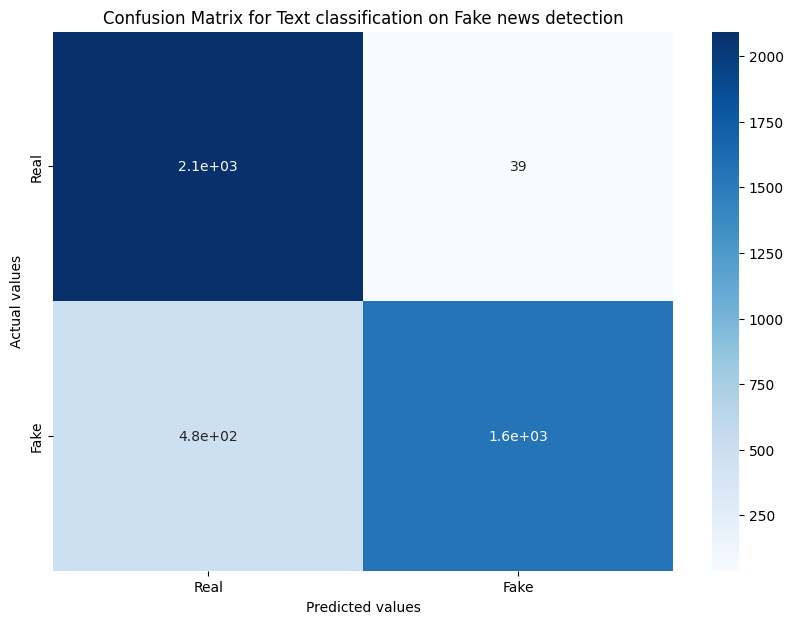

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(data=svm_cm, annot=True, cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion Matrix for Text classification on Fake news detection')
plt.show()

## Confusion Matrix result: 
**In this confusion matrix:**

* The top-left cell (2.1e+03) represents the number of true negatives (TN), i.e., the number of instances correctly predicted as real news.
* The top-right cell (39) represents the number of false positives (FP), i.e., the number of instances incorrectly predicted as fake news.
* The bottom-left cell (4.8e+02) represents the number of false negatives (FN), i.e., the number of instances incorrectly predicted as real news but they are actually fake news.
* The bottom-right cell (1.6e+03) represents the number of true positives (TP), i.e., the number of instances correctly predicted as fake news.

## News Prediction

In [33]:
# Predict on a single test instance
news_text = X_test[0]

# Reshape and predict
news_text_reshaped = news_text.reshape(1, -1)
prediction = naive_bayes_classifier.predict(news_text_reshaped)

if prediction[0] == 0:
    print("The news is Real")
else:
    print("The news is Fake")

# Correctly print the corresponding true label
print(f"True label: {y_test.iloc[0]}")

The news is Fake
True label: 1


## Result : The obtained prediction after training model is that the news is fake.